In [12]:
from sklearn.model_selection import train_test_split
from models.AST import AST
import librosa
import numpy as np
from torchinfo import summary
from torch import nn
from torch.optim import Adam
from Utils import read_data,create_dataloader, k_fold_cross_validation, train, test
import matplotlib.pyplot as plt

# Read Data 

In [3]:
sr = 16 * 1000
x,y,min_length = read_data(root='../Data/genres_original', sr=sr)
print("finsh reading data")

finsh reading data


# Conversion, Compression and Normalisation

In [4]:
top_db = 80
for i in range(len(x)):
    signal = x[i][:min_length]
    mel_spect = librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=1024) # convert signals to mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max, top_db=top_db) # log compression
    x[i] = mel_spect/-top_db # normalisation
print("finish conversion and compression")

finish conversion and compression


# Split Data

In [5]:
x = np.asarray(x)
x = x.transpose((0,2,1))
y = np.asarray(y)
print(x.shape)

(1000, 936, 128)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=y,shuffle=True)
# k-fold cross validation
k = 5
xs_train, ys_train, xs_valid, ys_valid = k_fold_cross_validation(x_train,y_train,k)
print("finish splitting data")

finish splitting data


# Create Dataloaders

In [7]:
batch_size = 16
dataloaders_train = []
dataloaders_valid = []
for i in range(k):
    dataloaders_train.append(create_dataloader(xs_train[i], ys_train[i], batch_size=batch_size))
    dataloaders_valid.append(create_dataloader(xs_valid[i], ys_valid[i], batch_size=batch_size))
dataloader_test = create_dataloader(x_test, y_test, batch_size=batch_size)
print("finish creating dataloaders")

finish creating dataloaders


# Model Construction

In [8]:
model = AST(10,input_fdim=x.shape[2],input_tdim=x.shape[1])
model.cuda()
loss_function = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=1e-5)
summary(model,[(batch_size,x.shape[1],x.shape[2])])

frequncey stride=10, time stride=10
number of patches=1116


E:\learning\master\1.2\COMP47700SA\Music-Genre-Classification\venv\lib\site-packages\timm\models\vision_transformer.py:91: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


Layer (type:depth-idx)                   Output Shape              Param #
AST                                      [16, 10]                  2,398,160
├─VisionTransformerDistilled: 1-3        --                        (recursive)
│    └─ASTPatchEmbed: 2-1                [16, 1116, 768]           --
│    │    └─Conv2d: 3-1                  [16, 768, 12, 93]         197,376
│    └─Dropout: 2-2                      [16, 1118, 768]           --
├─ModuleList: 1-2                        --                        --
│    └─Block: 2-3                        [16, 1118, 768]           --
│    │    └─LayerNorm: 3-2               [16, 1118, 768]           1,536
│    │    └─Attention: 3-3               [16, 1118, 768]           2,362,368
│    │    └─Identity: 3-4                [16, 1118, 768]           --
│    │    └─Identity: 3-5                [16, 1118, 768]           --
│    │    └─LayerNorm: 3-6               [16, 1118, 768]           1,536
│    │    └─Mlp: 3-7                     [16, 1118,

# Train

In [9]:
epoch = 10
history = train(model,loss_function,opt,dataloaders_train,dataloaders_valid,k,epoch=epoch)
print("finish training")

-------epoch  1 -------
fold 1:
train set loss: 2.31220703125
train set accuracy: 0.1171875
valid set loss: 2.247265625
valid set accuracy: 0.16875000298023224
fold 2:
train set loss: 2.275390625
train set accuracy: 0.1484375
valid set loss: 2.170703125
valid set accuracy: 0.35625001788139343
fold 3:
train set loss: 2.2361328125
train set accuracy: 0.19218750298023224
valid set loss: 2.098828125
valid set accuracy: 0.48125001788139343
fold 4:
train set loss: 2.201953125
train set accuracy: 0.2109375
valid set loss: 2.07841796875
valid set accuracy: 0.36250001192092896
fold 5:
train set loss: 2.16962890625
train set accuracy: 0.28125
valid set loss: 2.0521484375
valid set accuracy: 0.41875001788139343
epoch loss: 2.129
epoch accuracy: 0.358
-------epoch  2 -------
fold 1:
train set loss: 2.146728515625
train set accuracy: 0.3046875
valid set loss: 2.02841796875
valid set accuracy: 0.45625001192092896
fold 2:
train set loss: 2.1162109375
train set accuracy: 0.34687501192092896
valid set 

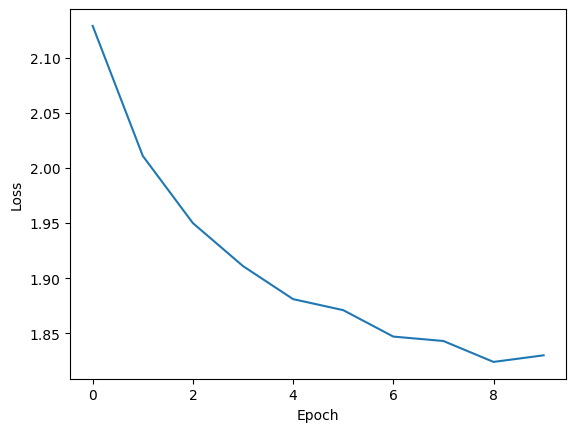

In [15]:
plt.plot(range(epoch),history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

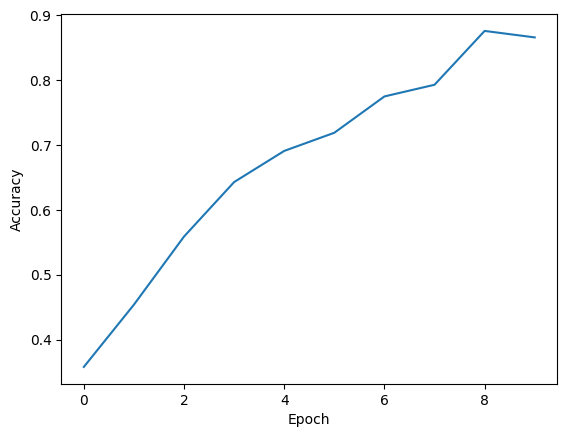

In [16]:
plt.plot(range(epoch),history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test

In [10]:
loss, acc, AUC, f1 = test(model,loss_function,dataloader_test)

test set loss: 1.887
test set accuracy: 0.74
test set AUC: 0.888
test set f1-score: 0.74


(1.887, 0.74, 0.888, 0.74)